# RESCUE
## *Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3. 
The main strucutre of the model include a two layer artificial neural net with the pinball loss function as objective. Conditional on combinations of input, the model should be able to output quantile forecast for the net-load forecast error.

In reality, the quantile forecast is trained on the response variable. For CAISO, as we are using RTPD forecast - RTD forecast as the response variable, the quantiles is actually on forecast difference rather than forecast error. Nevertheless, the model structure and the logic still holds the same.

This notebook contains the work load of ingesting pre-processed data, set up cross validation folds, training various model, and deployment. For detailed implementation of data preprocessing or quoted functions, please refer to other script files.

## *Advantage of the RESCUE package:*
1. Incorporating a wide gamut of information: weather, calendar, forecast, and lagged error aware. 
2. Inherrent handles resource correlation as solar,wind, and load errors are co-trained within the model.
3. Produces multiple prediction intervals for expected error in netload forecasting, for cherry picking down-stream
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast
5. Adheres to best practice in statistics: cross validation, normalization, early-stopping, etc.

*Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian*


## *To-do Items*


TODO: Standardize the output for stability;
TODO: Basic Data check and Assertion

In [1]:
# Import relevant packages
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import cross_val
import utility

In [2]:
## User Defined inputs
model_name = 'rescue_v1_1' # name of the model. Recommend to include version number

# Target quantiles of the prediction 
PI_percentiles = np.array([0.025, 0.05, 0.25, 0.5,0.75, 0.95, 0.975]) # quantiles to predict

# Structural parameter of the ANN network
num_neurons = 10
activation_type = 'relu'

# Cross validation parameters
num_cv_folds = 10 # number of cross validation folds

# Training parameters
batch_size = 64 # size of each mini-batch in the SGD
max_epochs = 50 # Maximum number of epochs in training. In each epoch, each training data is used exactly once
optimizer_choice = 'adam' # Optimizer choice. Default to ADAM, a popular choice that have 1st and 2nd order momentum

# Early stopping parameters
early_stop_monitor = 'val_loss' # The metrics to watch when deciding whether to stop. Recommendation: Validation loss as in 'val_loss'
early_stop_min_delta = 0.5 # if the difference/decrease in loss is less than min_delta, the model is considered no longer improving
early_stop_patience = 3 # For number of patience epochs, observe if the model has improved more than min_delta
early_stop_verbosity = 1 # 0: no output, 1: some output, 2: full output

## Constants
E3_colors = [[3,78,110],[175,126,0],[175,34,0],[0,126,51],[175,93,0],[10,25,120]] 
E3_colors = np.array(E3_colors)/255 # E3 color pallete


# 1. Data Ingestion

Load in net load forecast error data. Preprocessing of the data is handled by a separate package.
Use `tf.data` to batch and shuffle the dataset:

In [3]:
# Load in/ Create folder structure for the current model
dir_str = utility.Dir_Structure(model_name = model_name)

# Read in input and output of the training and validation samples from data pipeline
input_trainval = pd.read_pickle(dir_str.input_trainval_path)
output_trainval = pd.read_pickle(dir_str.output_trainval_path)

# Call function
val_masks_all_folds = cross_val.get_CV_masks(input_trainval.index, num_cv_folds, dir_str.shuffled_indices_path)

Performing day shuffling....
Done....
Creating train val masks for each fold....
Train and val masks are ready!


# 2. Model Definition
Define the stucture of the model from start to finish. Includes normalization layer, ANN model and pinball loss.

Build the ANN model with Pinball loss using the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing)
                        

In [5]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

In [6]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau

    def call(self, y_true, y_pred):
        err = y_true - y_pred
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse


class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP', initializer="zeros", dtype = tf.float64)
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
    

# Early stopping criteria is validation loss. 
# Min loss change of 1 in 2 epochs (patience)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                                     patience=early_stop_patience, verbose=early_stop_verbosity)

# we will overwrite the current checkpoint if and only if the `val_loss` score has improved.
# The saved model name will include the current epoch. and into the ckpts_dir folder
def get_cb_check_points(ckpts_dir, tau, fold_idx):
    # make sure models for different tau go to different directories
    ckpts_dir = os.path.join(ckpts_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(ckpts_dir):
        os.makedirs(ckpts_dir)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_dir, save_best_only=True, monitor="val_loss", verbose=0)
    return cb_check_points

# the tensorboard callback allow us to visualize and observe training history in a pre-compiled tensorboard interface.
# Currrently not logging the histogram of activation and embedding layers 
# Write log per epoch.

def get_cb_tensor_board(log_dir, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    log_dir = os.path.join(log_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    cb_tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, embeddings_freq=0,  update_freq="epoch")  
    return cb_tensor_board

def save_rescue_model(trained_models_dir, model, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    trained_models_dir = os.path.join(trained_models_dir, "tau_{:.0%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(trained_models_dir):
        os.makedirs(trained_models_dir)
    
    model.save(trained_models_dir)
    return None    


In [7]:
rescue_model_set = {}
history = {}

for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.1%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the validation masks of this CV fold
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # cast to 'float32'
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Transoform into tensorflow Dataset type for training
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)


        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        rescue_model_set[(tau, fold_idx)].get_layer(index = 1).adapt(input_trainval.values) 
        rescue_model_set[(tau, fold_idx)].compile(loss = PinballLoss(tau = tau), optimizer=optimizer_choice,
                                                  metrics= [CoverageProbability()])
        
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_tensor_board(log_dir, tau, fold_idx)])
        
        # Save the trained rescue model for each target percentile and fold
        save_rescue_model(trained_models_dir, rescue_model_set[(tau, fold_idx)], tau, fold_idx)


Training model for Prediction interval: 2.5%
Cross Validation fold # 1
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1396/1400 [============================>.] - ETA: 0s - loss: 56.4344 - CP: 0.1786WARNING:tensorflow:From C:\Users\yuchi\Anaconda3\envs\e3rescue\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\yuchi\PycharmProjects\RESCUE\ckpts\rescue_v1_1\tau_2%\fold_#0\assets
1400/1400 [==============================] - 3s 2ms/step - loss: 56.3669 - CP: 0.1782 - val_loss: 32.2014 - val_CP: 0.1656
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 28.8992 - CP: 0.1061 - val_loss: 28.9423 - val_CP: 0.1028
Epoch 3/50
1400/1400 [====================

Inferring on quantile of 2.5%
Inferring on quantile of 5.0%
Inferring on quantile of 25.0%
Inferring on quantile of 50.0%
Inferring on quantile of 75.0%
Inferring on quantile of 95.0%
Inferring on quantile of 97.5%


# 3. Visualization of training results

## 3.1 Tensorboard

In [8]:
# Initialize container for the inference result for different quantiles/CV folds
multi_index_tau_folds = pd.MultiIndex.from_product([PI_percentiles, range(num_cv_folds)], names = ['Quantiles','Fold ID'])
pred_trainval = pd.DataFrame(index = input_trainval.index, columns = multi_index_tau_folds)
# Initialize container for the training loss and metric history
num_metrics = len(history[(tau, fold_idx)].params['metrics'])
training_history = np.ones((len(PI_percentiles), num_cv_folds, max_epochs, num_metrics))*np.nan


for i,tau in enumerate(PI_percentiles):
    print ('Inferring on quantile of {:.1%}'.format(tau))
    for fold_idx in range(num_cv_folds):
        # Record training loss and metrics history
        num_epochs = len(history[(tau, fold_idx)].epoch)
        training_history[i,fold_idx,:num_epochs,:] = pd.DataFrame(history[(tau, fold_idx)].history).values
        
        # Deploy model on the trainval data and record inference results
        pred_trainval.loc[:,(tau,fold_idx)] = rescue_model_set[(tau,fold_idx)].predict(input_trainval.values)
        
#Output inferrence result and training history to hard drive        
pred_trainval.to_pickle(os.path.join(output_dir,'pred_trainval.pkl'))
np.save(os.path.join(trained_models_dir,'training_history.npy'), training_history)

## 3.1 Forecast uncertainty's relationship with input variables

### 3.1.1 Forecast uncertainty v.s. Solar production

In [18]:
def plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, input_var_name):
    
    assert 0.5 in pred_trainval.columns, "No median forecast found!"
    
    pred_trainval_groupedby_input = pred_trainval.groupby(input_var_discretized.values).mean()
    num_PI_pairs = (len(pred_trainval_groupedby_input.columns)-1)/2
    fig, axarr  = plt.subplots(2,1, sharex = True, gridspec_kw={"height_ratios":[1,1]})  
    
    for i,PI in enumerate(pred_trainval_groupedby_input.columns):
        if PI == 0.5:
            axarr[1].plot(pred_trainval_groupedby_input.index, pred_trainval_groupedby_input[0.5], 
                          label =  "Quantile = {:.1%}".format(0.5), color = E3_colors[1]) 
        elif PI<0.5:
            axarr[1].fill_between(pred_trainval_groupedby_input.index, pred_trainval_groupedby_input[PI], 
                                  pred_trainval_groupedby_input[1-PI], color =  1- (1-E3_colors[0])*(i+1)/(num_PI_pairs+1),
                                  label =  "Quantile: {:.1%} to  {:.1%}".format(PI, 1-PI))

    
    #axarr[1].scatter(input_trainval["Solar_RTPD_Forecast_T+1"], output_trainval, color = E3_colors[2], alpha = 0.005)
    
    axarr[1].set_ylabel('Quantile of Forecast Err (MW)')
    axarr[1].legend(frameon = False, loc = 'center left', bbox_to_anchor = [1,0.5])

    for i,PI in enumerate(pred_trainval_groupedby_input.columns):
        if PI<0.5:
            label = "P{:.0f}".format(100*(1-2*PI))
            upward_reserve = np.maximum(pred_trainval_groupedby_input[1-PI],0)
            downward_reserve = np.minimum(pred_trainval_groupedby_input[PI],0)
            
            # obtain the expected width of each bar
            input_var_range = pred_trainval_groupedby_input.index
            bar_width = ((input_var_range[-1] - input_var_range[0])
                         /(input_var_range.size - 1)*0.8)
            
            axarr[0].bar(input_var_range, upward_reserve, color = 1- (1-E3_colors[0])*(i+1)/(num_PI_pairs+1),
                         width = bar_width, label = label+" Up Reserve")
            axarr[0].bar(input_var_range, downward_reserve,  color = 1- (1-E3_colors[1])*(i+1)/(num_PI_pairs+1),
                         width = bar_width, label = label+" Down Reserve")

    axarr[0].legend(frameon = False, loc = 'center left', bbox_to_anchor = [1,0.5])
    axarr[0].set_ylabel('Reserves (MW)')

    axarr[0].set_title('Forecast uncertainty v.s. '+ input_var_name)
    axarr[-1].set_xlabel(input_var_name)

    fig.set_size_inches(8,6)
    fig.tight_layout()
    fig.savefig(input_var_name +'.png')
    
    return fig, axarr

def discretize_var(input_var, n_bins = 50):
    input_var_bins = np.linspace(input_var.min(), input_var.max(), n_bins)
    input_var_labels = (input_var_bins[:-1] + input_var_bins[1:])/2 
    input_var_discretized =  pd.cut(input_var, bins = input_var_bins, precision = 0,
                                    labels = input_var_labels, include_lowest= True)
    
    return input_var_discretized

In [13]:
pred_trainval = pd.read_pickle(os.path.join(output_dir,'pred_trainval.pkl'))
pred_trainval = pred_trainval.xs(0, axis=1, level = 'Fold ID')

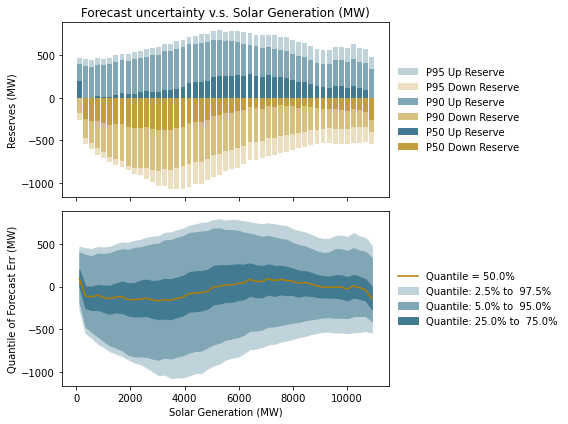

In [19]:
# Demonstrate the change in forecast uncertainty with respect to solar generation
input_var_discretized = discretize_var(input_trainval["Solar_RTPD_Forecast_T+1"])
fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Solar Generation (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# input_var_discretized = discretize_var(input_trainval["Wind_RTPD_Forecast_T+1"])
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Wind Generation (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# input_var_discretized = discretize_var(input_trainval["Load_RTPD_Forecast_T+1"])
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Load (MW)")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# diurnal_var = pred_trainval.index.hour
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, diurnal_var, "Hour")

# # Demonstrate the change in forecast uncertainty with respect to solar generation
# seasonal_var = pred_trainval.index.month
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, seasonal_var, "Month")

# # Demonstrate the change in forecast uncertainty with respect to days
# input_var_discretized = discretize_var(input_trainval['Days_from_Start_Date_T+1'])
# input_var_discretized = pd.Timestamp('20170101') + input_var_discretized.astype('int')*pd.Timedelta('1D')
# fig, axarr = plot_quantile_forecast_against_var(pred_trainval, input_var_discretized, "Date of Observation")
# fig.autofmt_xdate()

No handles with labels found to put in legend.


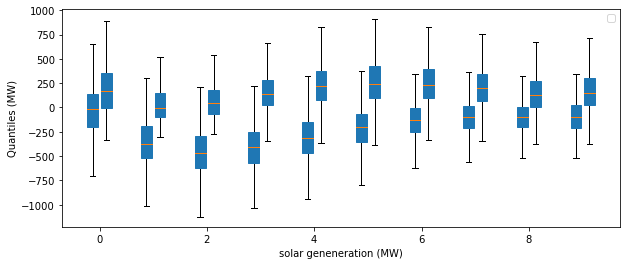

In [159]:
## Archived Code to produce Violin plot and Boxplot as quatile forecast respond to certain variable
# fig, ax = plt.subplots()

# for i,PI in enumerate([0.25,0.75]):
#     pred_trainval_gb = pred_trainval.groupby(solar_gen_bin.values)
#     pred_trainval_groupedby_solar = [pred_trainval_gb.get_group(cat)[PI] for cat in pred_trainval_gb.groups]
#     ax.boxplot(pred_trainval_groupedby_solar, showfliers= False, widths = 0.2, manage_ticks = False, patch_artist= True,
#                boxprops={"color":"C"+str(i)}, positions= np.arange(len(bin_edges)-1)+(PI-0.5)/2) 
        

# ax.set_ylabel('Quantiles (MW)')
# ax.set_xlabel('solar geneneration (MW)')
# ax.legend()

# fig.set_size_inches(10,4)

# fig, ax = plt.subplots()

# for i,PI in enumerate([0.25,0.75]):
#     for solar_bin in pred_trainval['solar_gen_bin'].unique():
#         violin_patches = ax.violinplot(pred_trainval.loc[pred_trainval['solar_gen_bin'] == solar_bin, PI],
#                                      positions = [solar_bin+(PI-0.5)/5], showmedians = False, showextrema = False)
        
#         for p in violin_patches['bodies']:
#             p.set_facecolor(colors[i])
#             p.set_alpha(0.3)

# ax.set_ylabel('Quantiles (MW)')
# ax.set_xlabel('solar geneneration (MW)')
# ax.legend()

# fig.set_size_inches(10,4)

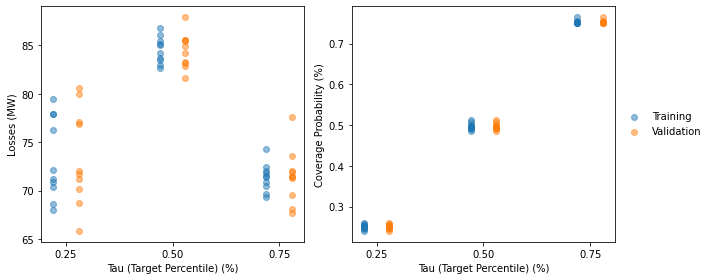

In [80]:
# Visualizing cross-validation performance and generalizability of the model
# reassemble the best performing model's loss
train_losses = pd.DataFrame(None, index = PI_percentiles)
val_losses = train_losses.copy()
train_cp = train_losses.copy()
val_cp = train_losses.copy()

for tau in PI_percentiles:
    for fold_idx in range(num_cv_folds):
        train_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['loss'][-1]
        train_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['CP'][-1]
        val_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['val_loss'][-1]
        val_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['val_CP'][-1]

# Visualization of the training process

fig, axarr = plt.subplots(1,2, sharex = True)
train_x_pos =np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,num_cv_folds)) - 0.03
val_x_pos = np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,num_cv_folds)) + 0.03

axarr[0].scatter(train_x_pos.ravel(), train_losses.values.ravel(),label = 'Training', alpha = 0.5)
axarr[0].scatter(val_x_pos.ravel(), val_losses.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[0].set_xticks(PI_percentiles)
axarr[0].set_xlabel('Tau (Target Percentile) (%)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].scatter(train_x_pos.ravel(), train_cp.values.ravel(), label = 'Training' ,alpha = 0.5)
axarr[1].scatter(val_x_pos.ravel(), val_cp.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[1].set_xticks(PI_percentiles)
axarr[1].set_xlabel('Tau (Target Percentile) (%)')
axarr[1].set_ylabel('Coverage Probability (%)')
axarr[1].axhline(PI_percentiles, dashes = [2,2], color = 'k')


axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('cross_validation_and_generalizability.png', bbox_inches = 'tight')

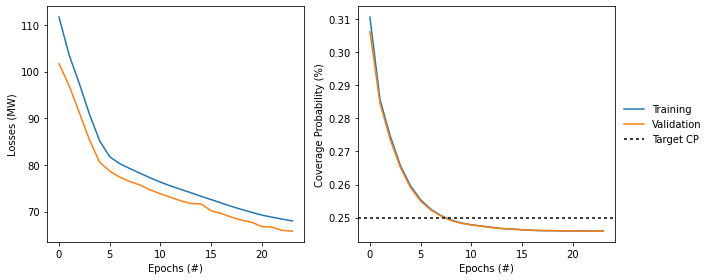

In [81]:
fig, axarr = plt.subplots(1,2, sharex = True)
history_eg = history[(0.25,0)].history

axarr[0].plot(history_eg['loss'],label = 'Training')
axarr[0].plot(history_eg['val_loss'], label = 'Validation')

axarr[0].set_xlabel('Epochs (#)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].plot(history_eg['CP'], label = 'Training')
axarr[1].plot(history_eg['val_CP'], label = 'Validation')
axarr[1].axhline(0.25, label = 'Target CP', dashes = [2,2], color = 'k')
axarr[1].set_xlabel('Epochs (#)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('training_history.png', bbox_inches = 'tight')

# 3. Deploying the model

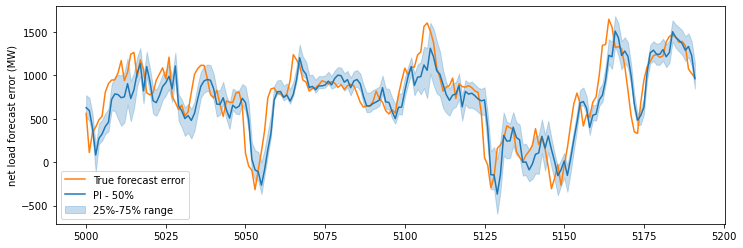

In [10]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, color = 'C1', label = 'True forecast error')

# plot median forecast if it is being produced
if 0.5 in PI_percentiles:
    ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), color = 'C0', label = 'PI - 50%')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)),
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)),
                        color = 'C0', alpha = PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))

ax.set_ylabel("net load forecast error (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

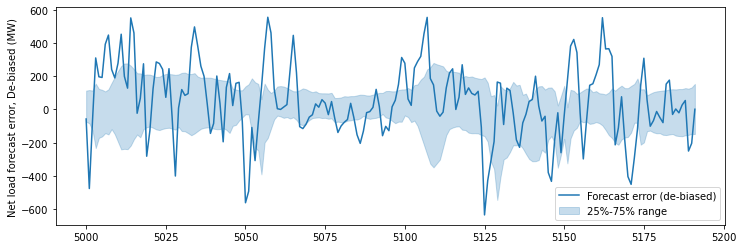

In [10]:
fig,ax = plt.subplots()
inherent_bias_eg = np.squeeze(rescue_model_set[0.5].predict(input_val[example_range]))

ax.plot(example_range, np.squeeze(output_val_eg) - inherent_bias_eg, label = 'Forecast error (de-biased)')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)) - inherent_bias_eg,
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)) - inherent_bias_eg,
                        color = 'C0', alpha =PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))


ax.set_ylabel("Net load forecast error, De-biased (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

Choose an optimizer and loss function for training: 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
@tf.function
def train_step(inputs, outputs, model, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(inputs, training=True)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, rescue.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

    train_loss(loss)
    #train_accuracy(outputs, predictions)


@tf.function
def test_step(inputs, outputs, model, loss_fn):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = rescue(inputs, training=False)
    t_loss = loss_object(outputs, predictions)

    test_loss(t_loss)
    #test_accuracy(outputs, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
